In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
import tensorflow as tf

Using TensorFlow backend.


In [3]:
true = pd.read_csv("kaggle/input/True.csv")
false = pd.read_csv("kaggle/input/Fake.csv")

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true['category'] = 1
false['category'] = 0

In [7]:
df = pd.concat([true, false])

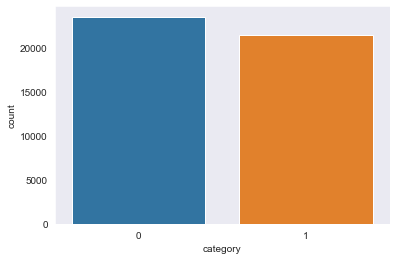

In [8]:
sns.set_style("dark")
sns.countplot(df.category)

In [9]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [11]:
df.title.count()

44898

In [12]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

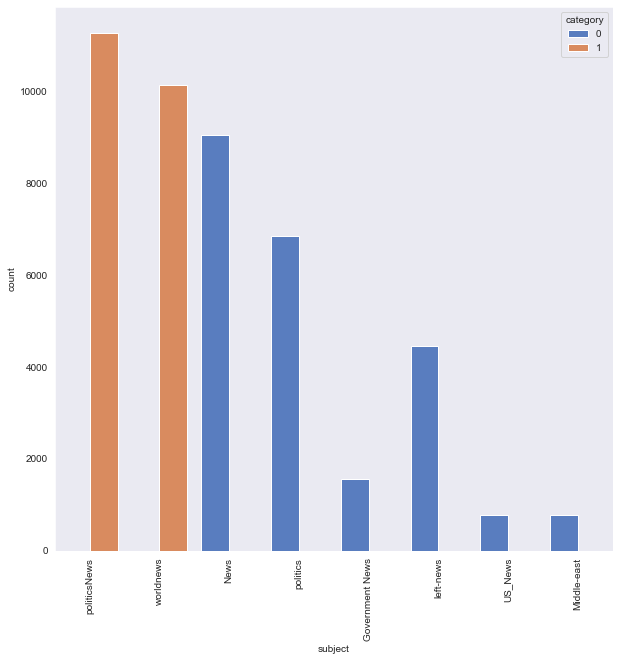

In [13]:
plt.figure(figsize = (10, 10))
sns.set_style("dark")
chart = sns.countplot(x = "subject", hue = "category", data = df, palette = "muted")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [14]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [17]:
# nltk.download("stopwords")
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [20]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

df['text'] = df['text'].apply(denoise_text)

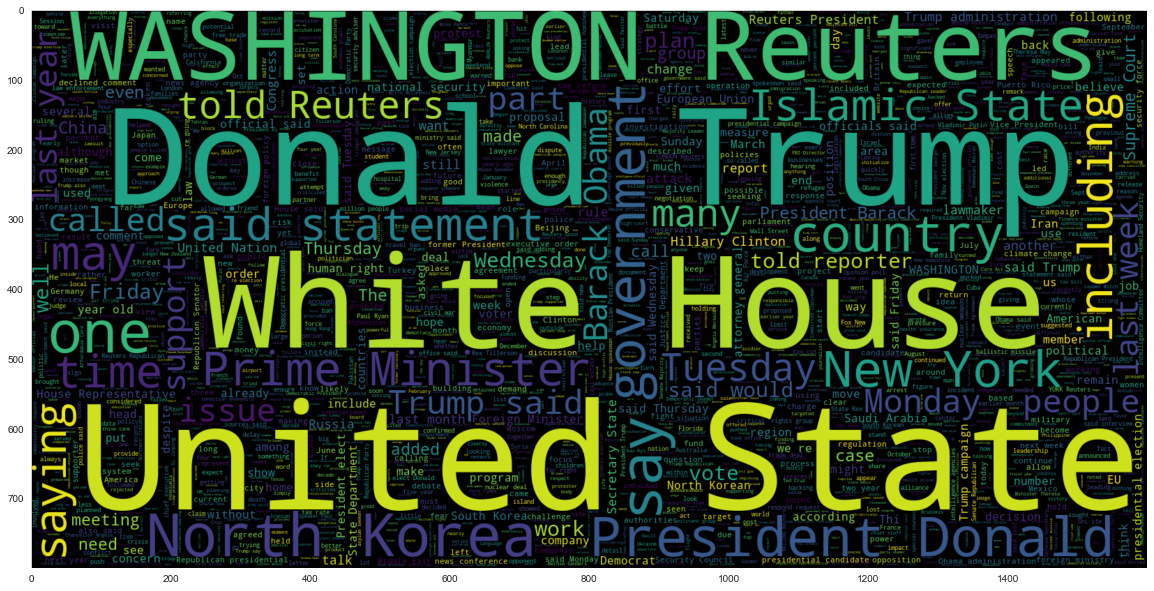

In [23]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.category==1].text))
plt.imshow(wc, interpolation = 'bilinear')

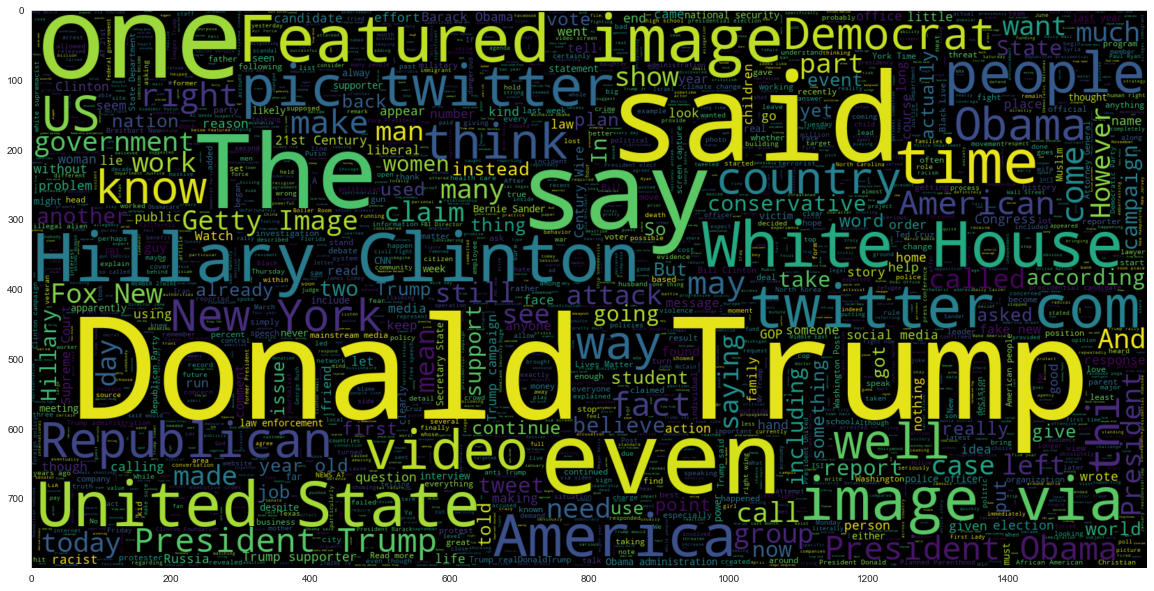

In [24]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.category==0].text))
plt.imshow(wc, interpolation = 'bilinear')

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, random_state = 0)


In [26]:
max_features = 10000
maxlen = 300


In [28]:
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen = maxlen)

In [30]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen = maxlen)

In [40]:
EMBEDDING_FILE = 'kaggle/input/glove.twitter.27B.100d.txt'

In [43]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = 'float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding = 'utf-8'))

In [45]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i>=max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [46]:
batch_size = 256
epochs = 10
embed_size = 100

In [47]:
model = Sequential()

model.add(Embedding(max_features, output_dim = embed_size, weights = [embedding_matrix], input_length = maxlen, trainable = False))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [49]:
history = model.fit(x_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test), epochs = epochs)

Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 2432s 72ms/step - loss: 0.1716 - accuracy: 0.9323 - val_loss: 0.0955 - val_accuracy: 0.9644
Epoch 2/10
  512/33673 [..............................] - ETA: 44:04 - loss: 0.0943 - accuracy: 0.9629

KeyboardInterrupt: 

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

In [ ]:
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[0].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[0].plot(epochs, val_loss, 'ro-', label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake', 'Not Fake']))

In [ ]:
cm - confusion_matrix(y_test, pred)
cm

In [ ]:
cm = pd.DataFrame(cm, index = ['Fake', 'Not Fake'], columns = ['Fake', 'Not Fake'])

In [ ]:
plt.figure(figsize = (10, 10))
sns.hearmap(cm, cmap = "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt = '', xticklabels = ['Fake', 'Not Fake'], yticklabels = ['Fake', 'Not Fake'])